## AQUA TABLE
### CONVERT TO ANEOS STD+EXT FORMATS FOR COMPATIBILITY WITH EOS_TABLE MODULE

S. T. Stewart

2/16/2022


In [1]:
# Record the verions information for these calculation for posterity
import platform
print('python version: ',platform.python_version())
del platform
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
del matplotlib
import numpy
print('numpy version: ', numpy.__version__)
del numpy
import scipy
print('scipy version: ', scipy.__version__)
del scipy
#import pandas
#print('pandas version: ', pandas.__version__)
#del pandas

# this prevents some error messages for inline plotting in a jupyter notebook
#%matplotlib inline 
# import python libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
import numpy as np
#from scipy import interpolate
from scipy.io import readsav # read IDL sav files
import colormaps as local_cmaps
import subprocess


import eos_table as etab # Stewart group EOS table libraries
print('eos_table version: ', etab.__version__)
#
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["patch.force_edgecolor"] = True
#


python version:  3.9.13
matplotlib version:  3.5.2
numpy version:  1.21.5
scipy version:  1.9.1
eos_table version:  v1.1.2


In [2]:
MODELNAME='AQUA-v1.0'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 230215.     # Date as a single 6-digit number YYMMDD
VERSION = 1.0      # ANEOS Parameters Version number
FMN = 10           # Formula weight in atomic numbers H2O
FMW = 18.          # Formula molecular weight (g/mol) for H2O
# The following define the default initial state for material in the 201 table
R0REF   = 1.0      # g/cm3 *** R0REF is inserted into the density array
K0REF   = 2E10     # dynes/cm2
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
#
# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------
NewEOS  = etab.extEOStable() # FIRST make new empty EOS object
#NewEOS.loadextsesame('NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
#NewEOS.loadstdsesame('NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#

In [3]:
# read in AQUA rho-T table

# columns and units
# rho kg/m3; temp K; press Pa; ad grad; s J/K/kg; U J/kg; c m/s; mmw kg/mol; xion; xd; phase 
filename = 'aqua_eos_rhot_v1_0.dat'
nrho = 1501
ntemp = 301

rhoarr=np.loadtxt(filename,skiprows=21,usecols=[0])
tarr=np.loadtxt(filename,skiprows=21,usecols=[1])
parr=np.loadtxt(filename,skiprows=21,usecols=[2])
adarr=np.loadtxt(filename,skiprows=21,usecols=[3])
sarr=np.loadtxt(filename,skiprows=21,usecols=[4])
uarr=np.loadtxt(filename,skiprows=21,usecols=[5])
csarr=np.loadtxt(filename,skiprows=21,usecols=[6])
phasearr=np.loadtxt(filename,skiprows=21,usecols=[10]) # phase integer (main are minus 7 to plus 5)
#print(rhoarr[0:10])
#print(tarr[0:10])
#print(parr[0:10])
#print(sarr[0:10])
#print(uarr[0:10])
#print(csarr[0:10])
gridrarr = np.unique(rhoarr)
gridtarr = np.unique(tarr)

# reshape the arrays from (density,temperature) to (temperature, density)

# standard SESAME TABLE UNITS
NewEOS.units = 'Units: rho g/cm3, T K, P GPa, U MJ/kg, A MJ/kg, S MJ/K/kg, cs cm/s, cv MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

NewEOS.ND  = nrho
NewEOS.NT  = ntemp 
NewEOS.rho = gridrarr /1.e3  # kg/m3 -> g/cm3
NewEOS.T   = gridtarr # K
tmp = deepcopy(parr.reshape(NewEOS.ND,NewEOS.NT))
NewEOS.P   = np.swapaxes(tmp,0,1)/1.E9 # Pa->GPa
tmp = []
tmp = deepcopy(uarr.reshape(NewEOS.ND,NewEOS.NT))
NewEOS.U   = np.swapaxes(tmp,0,1)/1.E6 # J/kg->MJ/kg
tmp = []
tmp = deepcopy(sarr.reshape(NewEOS.ND,NewEOS.NT))
NewEOS.S   = np.swapaxes(tmp,0,1)/1.E6 # J/K/kg -> MJ/K/kg
tmp = []
tmp = deepcopy(csarr.reshape(NewEOS.ND,NewEOS.NT))
NewEOS.cs  = np.swapaxes(tmp,0,1)*100. # m/s -> cm/s
tmp = []
tmp = deepcopy(phasearr.reshape(NewEOS.ND,NewEOS.NT))
NewEOS.KPA  = np.swapaxes(tmp,0,1) # integer flag with phase information
tmp = []
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ integer array
NewEOS.A = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty HFE array
NewEOS.cv = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty HFE array

print('done loading AQUA table')

done loading AQUA table


In [4]:
print('Min pressure (Pa)',min(parr))
print('Min density (g/cm3)',min(NewEOS.rho))
print('Max density (g/cm3)',max(NewEOS.rho))
print('Min temperature (T)',min(NewEOS.T))
print('Max temperature (T)',max(NewEOS.T))


Min pressure (Pa) 1.08566258e-14
Min density (g/cm3) 1e-13
Max density (g/cm3) 100.0
Min temperature (T) 100.0
Max temperature (T) 100000.0


In [5]:
# Read in phase boundaries from NIST
# UNITS: t K, rho kg/m3, P MPa, E kJ/kg, S kJ/kg/K
# have as IDL sav files
dir='./phase-boundaries/'
meltcurvefile = dir+'meltcurve.sav'
meltcurve = readsav(meltcurvefile)
#print(meltcurve.keys())
#print(meltcurve['tmeltall'])
satcurvefile = dir+'satcurve.sav'
satcurve = readsav(satcurvefile)
#print(satcurve.keys())
subcurvefile = dir+'subcurve.sav'
subcurve = readsav(subcurvefile)
#print(subcurve.keys())


NewEOS.vc.T = satcurve['tsatall'] # K
NewEOS.vc.P = satcurve['psatall']/1.e3 # MPa -> GPa
NewEOS.vc.rl = satcurve['dlsatall']/1.e3 # kg/m3 -> g/cm3
NewEOS.vc.rv = satcurve['dvsatall']/1.e3 # kg/m3 -> g/cm3
NewEOS.vc.sl = satcurve['slsatall']/1.e3 # kJ/K/kg -> MJ/K/kg
NewEOS.vc.sv = satcurve['svsatall']/1.e3 # kJ/K/kg -> MJ/K/kg
NewEOS.vc.el = satcurve['elsatall']/1.e3 # kJ/kg -> MJ/kg
NewEOS.vc.ev = satcurve['evsatall']/1.e3 # kJ/kg -> MJ/kg

NewEOS.mc.T = meltcurve['tmeltall']# K
NewEOS.mc.P = meltcurve['pmeltall']/1.e3 # MPa -> GPa
NewEOS.mc.rl = meltcurve['dmeltall']/1.e3 # kg/m3 -> g/cm3
NewEOS.mc.rs = meltcurve['dice1meltall']/1.e3 # kg/m3 -> g/cm3
NewEOS.mc.sl = meltcurve['smeltall']/1.e3 # kJ/K/kg -> MJ/K/kg
NewEOS.mc.ss = meltcurve['sice1meltall']/1.e3 # kJ/K/kg -> MJ/K/kg
NewEOS.mc.el = meltcurve['emeltall']/1.e3 # kJ/kg -> MJ/kg
NewEOS.mc.es = meltcurve['eice1meltall']/1.e3 # kJ/kg -> MJ/kg

NewEOS.mc.NT = (len(NewEOS.mc.rl))
#print(len(NewEOS.mc.rs))



## Save ANEOS TABLE FORMATS

In [6]:
NewEOS.writestdsesame(writestdsesfname='NEW-SESAME-STD.TXT')


Done writing the STD SESAME 301 table to local directory:  NEW-SESAME-STD.TXT


In [7]:
NewEOS.writeextsesame(writeextsesfname='NEW-SESAME-EXT.TXT')


Done writing the EXT SESAME 301 table to local directory:  NEW-SESAME-EXT.TXT


## Plot AQUA TABLE

/var/folders/jb/mzdd7n5504bdfp6q4j6w3gxm0000gn/T/ipykernel_66501/1644461110.py:110: RuntimeWarning: invalid value encountered in log10
  im1=ax4.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.S)+4.)/4.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
/var/folders/jb/mzdd7n5504bdfp6q4j6w3gxm0000gn/T/ipykernel_66501/1644461110.py:132: RuntimeWarning: invalid value encountered in log10
  ax5.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.S)+4.)/4.,cmap=local_cmaps.parula,vmin=0,vmax=1)


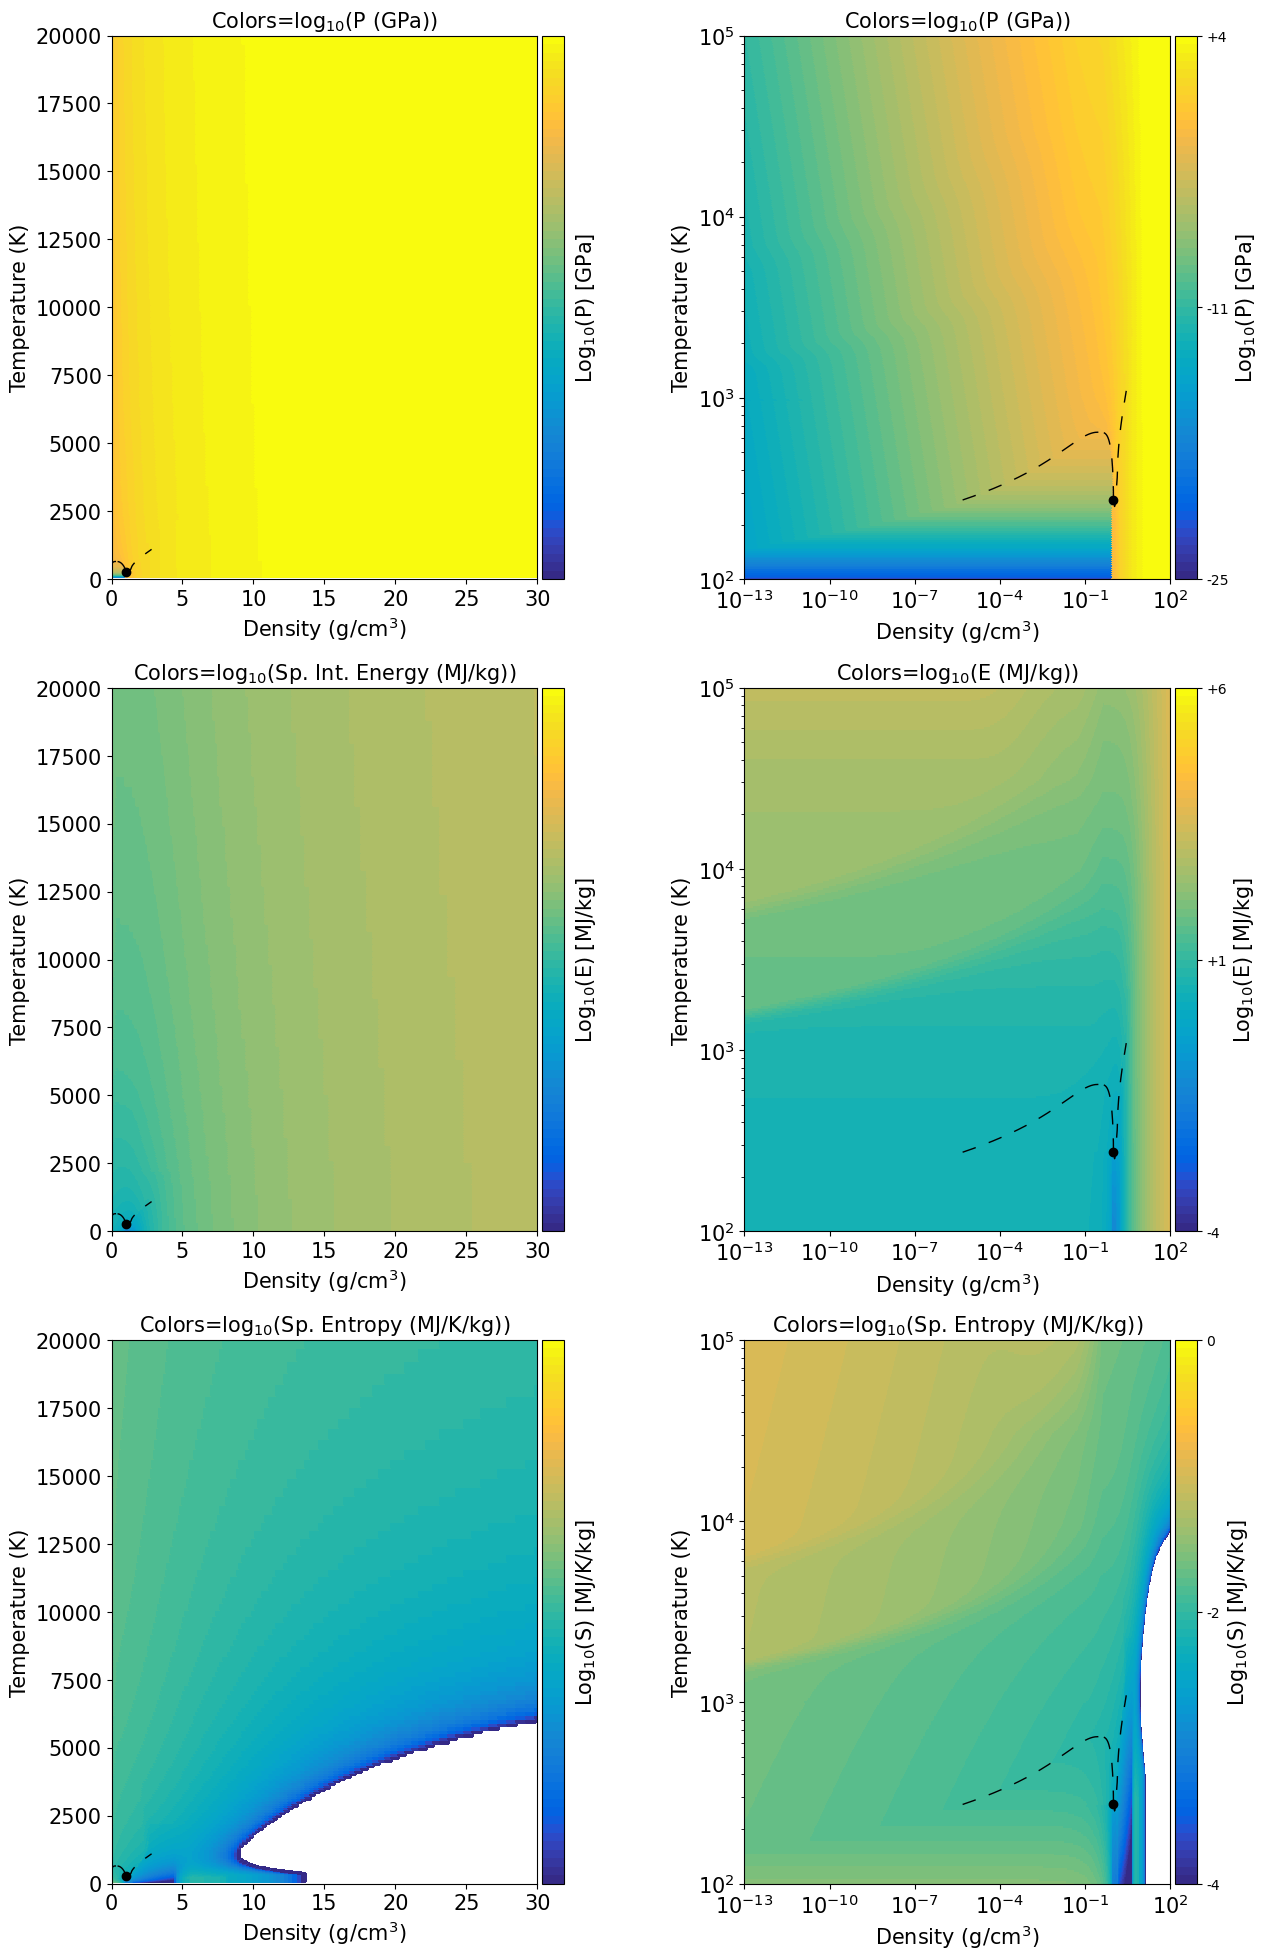

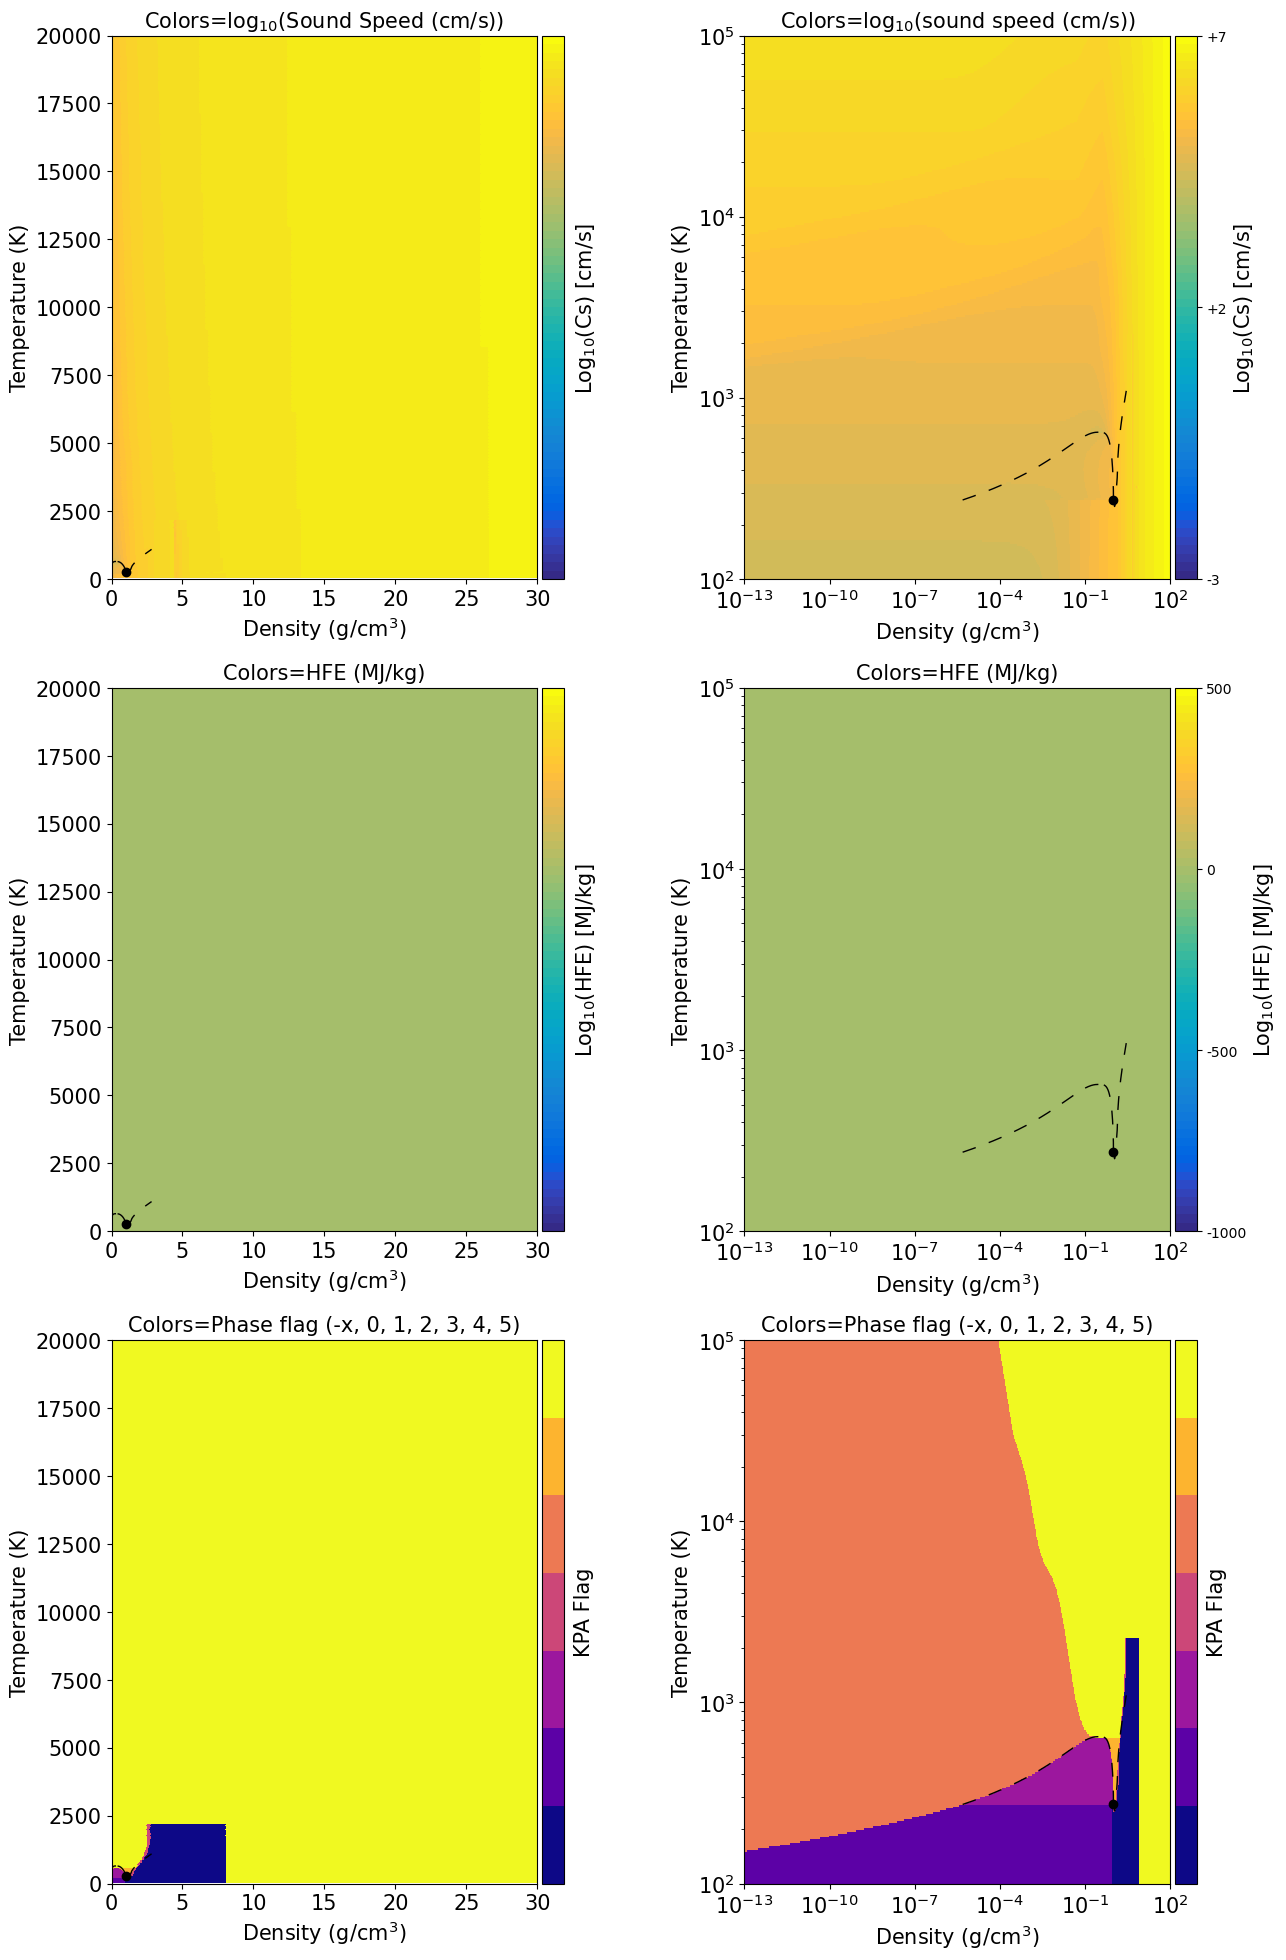

In [10]:
# PLOT COLOR SHADED VALUES RHO-T TABLE
lw=1
sfont = 15
ds = (10,10)
plt.rcParams['pcolor.shading'] ='nearest'

xr2 = [min(NewEOS.rho),max(NewEOS.rho)]
yr2 = [min(NewEOS.T),max(NewEOS.T)]


%matplotlib inline
fig, ([ax0, ax1], [ax2,ax3], [ax4,ax5])= plt.subplots(nrows=3,ncols=2,figsize=(14,24))
plt.subplots_adjust(wspace=0.4)
#plt.tight_layout(pad=0.6)

##================ Pressure
im1=ax0.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.P)+25)/29.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax0.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax0.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax0.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax0.set_ylim(0.,20000)
ax0.set_xlim(0,30.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Temperature (K)',size=sfont)
ax0.set_title('Colors=log$_{10}$(P (GPa))',size=sfont)
ax0.tick_params(labelsize=sfont)

divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
cbar0 = fig.colorbar(im1, cax=cax0, ticks = [],orientation='vertical')
#cbar0.ax.set_yticklabels(['  ','  ','  '])  # vertical colorbar
cbar0.set_label('Log$_{10}$(P) [GPa]',size=sfont)
#cbar0.ax.set_yticklabels(['-25','-11','+4'])  # vertical colorbar

im1=ax1.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.P)+25)/29.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax1.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax1.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax1.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax1.set_ylim(yr2)
ax1.set_xlim(xr2)
ax1.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax1.set_ylabel('Temperature (K)',size=sfont)
ax1.set_title('Colors=log$_{10}$(P (GPa))',size=sfont)
ax1.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-25','-11', '+4'])  # vertical colorbar
cbar.set_label('Log$_{10}$(P) [GPa]',size=sfont)


#================ Sp. Int. Energy
im1=ax2.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.U)+4.)/10.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax2.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax2.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax2.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax2.set_ylim(0.,20000)
ax2.set_xlim(0,30.)
ax2.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax2.set_ylabel('Temperature (K)',size=sfont)
ax2.set_title('Colors=log$_{10}$(Sp. Int. Energy (MJ/kg))',size=sfont)
ax2.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
# does not want to label ticks in this location
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['','',''])  # vertical colorbar
cbar.set_label('Log$_{10}$(E) [MJ/kg]',size=sfont)
#cbar.ax.set_yticklabels(['-4','+1','+6'])  # vertical colorbar


ax3.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.U)+4.)/10.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax3.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax3.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax3.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax3.set_ylim(yr2)
ax3.set_xlim(xr2)
ax3.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax3.set_ylabel('Temperature (K)',size=sfont)
ax3.set_title('Colors=log$_{10}$(E (MJ/kg))',size=sfont)
ax3.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-4', '+1','+6'])  # vertical colorbar
cbar.set_label('Log$_{10}$(E) [MJ/kg]',size=sfont)

#================ Sp. Entropy
im1=ax4.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.S)+4.)/4.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax4.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax4.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax4.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax4.set_ylim(0.,20000)
ax4.set_xlim(0,30.)
ax4.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax4.set_ylabel('Temperature (K)',size=sfont)
ax4.set_title('Colors=log$_{10}$(Sp. Entropy (MJ/K/kg))',size=sfont)
ax4.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-4', '-2', '0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(S) [MJ/K/kg]',size=sfont)


ax5.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.S)+4.)/4.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax5.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax5.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax5.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax5.set_ylim(yr2)
ax5.set_xlim(xr2)
ax5.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax5.set_ylabel('Temperature (K)',size=sfont)
ax5.set_title('Colors=log$_{10}$(Sp. Entropy (MJ/K/kg))',size=sfont)
ax5.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-4', '-2','0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(S) [MJ/K/kg]',size=sfont)

fig.savefig('AQUA-eos-plot1.png')

##============= start new plot
fig2, ([ax0, ax1], [ax2,ax3], [ax4,ax5])= plt.subplots(nrows=3,ncols=2,figsize=(14,24))
plt.subplots_adjust(wspace=0.4)

#================ Sound Speed
im1=ax0.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.cs)+3.)/10.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax0.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax0.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax0.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax0.set_ylim(0.,20000)
ax0.set_xlim(0,30.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Temperature (K)',size=sfont)
ax0.set_title('Colors=log$_{10}$(Sound Speed (cm/s))',size=sfont)
ax0.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-3', '+2', '+7'])  # vertical colorbar
cbar.set_label('Log$_{10}$(Cs) [cm/s]',size=sfont)


ax1.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.cs)+3.)/10.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax1.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax1.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax1.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax1.set_ylim(yr2)
ax1.set_xlim(xr2)
ax1.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax1.set_ylabel('Temperature (K)',size=sfont)
ax1.set_title('Colors=log$_{10}$(sound speed (cm/s))',size=sfont)
ax1.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-3', '+2', '+7'])  # vertical colorbar
cbar.set_label('Log$_{10}$(Cs) [cm/s]',size=sfont)


#================ HFE
amin = np.min(NewEOS.A)
amin = -1000.
alogmax = 1500. #np.max(anaarrodd)-amin #np.max(np.log10(anaarrodd-amin))
#print('amin, log10(amin)',amin,np.log10(-amin))
#print('alogmax=',alogmax)
im1=ax2.pcolormesh(NewEOS.rho,NewEOS.T,(NewEOS.A-amin)/alogmax,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax2.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax2.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax2.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax2.set_ylim(0.,20000)
ax2.set_xlim(0,30.)
ax2.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax2.set_ylabel('Temperature (K)',size=sfont)
ax2.set_title('Colors=HFE (MJ/kg)',size=sfont)
ax2.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-1000','-500','0','500'])  # vertical colorbar
cbar.set_label('Log$_{10}$(HFE) [MJ/kg]',size=sfont)


ax3.pcolormesh(NewEOS.rho,NewEOS.T,(NewEOS.A-amin)/alogmax,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax3.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax3.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax3.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax3.set_ylim(yr2)
ax3.set_xlim(xr2)
ax3.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax3.set_ylabel('Temperature (K)',size=sfont)
ax3.set_title('Colors=HFE (MJ/kg)',size=sfont)
ax3.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0,.333,.6667,  1], orientation='vertical')
cbar.ax.set_yticklabels(['-1000','-500','0','500'])  # vertical colorbar
cbar.set_label('Log$_{10}$(HFE) [MJ/kg]',size=sfont)



#================ KPA flag
cmap2 = cm.get_cmap('plasma', 7)    # 6 discrete colors
phasetmp = deepcopy(NewEOS.KPA)
ineg =np.where(phasetmp <0.)
phasetmp[ineg]= -1.
#im1=ax4.pcolormesh(NewEOS.rho,NewEOS.T,((NewEOS.KPA)+1.5)/7.,cmap=cmap2,vmin=0,vmax=1,edgecolors='face')
im1=ax4.pcolormesh(NewEOS.rho,NewEOS.T,((phasetmp)+1.5)/7.,cmap=cmap2,vmin=0,vmax=1,edgecolors='face')
#im1=ax4.pcolormesh(NewEOS.rho,NewEOS.T,((NewEOS.KPA))/6.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax4.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax4.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax4.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax4.set_ylim(0.,20000)
ax4.set_xlim(0,30.)
ax4.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax4.set_ylabel('Temperature (K)',size=sfont)
ax4.set_title('Colors=Phase flag (-x, 0, 1, 2, 3, 4, 5)',size=sfont)
ax4.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['0','1','2','3','4','5',  '6'])  # vertical colorbar
cbar.set_label('KPA Flag',size=sfont)


ax5.pcolormesh(NewEOS.rho,NewEOS.T,((phasetmp)+1.5)/7.,cmap=cmap2,vmin=0,vmax=1)
#ax5.pcolormesh(NewEOS.rho,NewEOS.T,((NewEOS.KPA)+1.5)/7.,cmap=cmap2,vmin=0,vmax=1)
ax5.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax5.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax5.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax5.set_ylim(yr2)
ax5.set_xlim(xr2)
ax5.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax5.set_ylabel('Temperature (K)',size=sfont)
ax5.set_title('Colors=Phase flag (-x, 0, 1, 2, 3, 4, 5)',size=sfont)
ax5.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
#cbar = fig.colorbar(im1, cax=cax, ticks = np.arange(13)/12, orientation='vertical')
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['','1','','2','','3','','4','','5','',  '6'])  # vertical colorbar
cbar.set_label('KPA Flag',size=sfont)

fig2.savefig('AQUA-eos-plot2.png')

# phase     1        I3      Phase id (vapor+ice: 0, vapor+liquid: 1, ice+liquid: 2, vapor: 3, liquid: 4, supercritical+superionic: 5,
#                            ice-Ih: -1, ice-II: -2, ice-III: -3, ice-V: -5, ice-VI:-6, ice-VII/X: -7, ice-Ih+ice-II: -12,            
#                            ice-Ih+ice-III: -13, ice-II+ice-III: -23, ice-II+ice-V: -25, ice-II+ice-VI: -26,ice-III+ice-V: -35,      
#                            ice-III+ice-VI: -36, ice-VI+ice-VII: -67, ice-X+superionic: -10)  



## AQUA PHASE ID NUMBERS

Phase id (vapor+ice: 0, vapor+liquid: 1, ice+liquid: 2, vapor: 3, liquid: 4, supercritical+superionic: 5,

ice-Ih: -1, ice-II: -2, ice-III: -3, ice-V: -5, ice-VI:-6, ice-VII/X: -7, ice-Ih+ice-II: -12,            

ice-Ih+ice-III: -13, ice-II+ice-III: -23, ice-II+ice-V: -25, ice-II+ice-VI: -26,ice-III+ice-V: -35,      

ice-III+ice-VI: -36, ice-VI+ice-VII: -67, ice-X+superionic: -10)  


### END